# Brain Tumor Classification and Segmentation
Kelompok 17: 
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Albertus Edbert Chandrajaya - 2702345440

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Dataset Preparation
## Dataset Gathering

In [6]:
DATA_PATH = 'data/'
TARGET_SIZE = (256, 256)

images = []
masks = []
labels = []

def z_score_normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / std

for folder in os.listdir(DATA_PATH):
    label = folder
    folder_path = os.path.join(DATA_PATH, folder)
    
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, TARGET_SIZE)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        img_zscore = z_score_normalize(gray)
        
        if image_file.endswith('_mask.png'):
            masks.append((gray > 127).astype(np.uint8))
        else:
            image_norm = cv2.normalize(img_zscore, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) # Z-Score Normalization with Min-Max Scaling
            images.append(image_norm)
            labels.append(label)
        
X = np.array(images)
M = np.array(masks)

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(np.array(labels).reshape(-1, 1))

print(f'Images shape: {X.shape}')
print(f'Masks shape: {M.shape}')
print(f'Labels shape: {y.shape}')

Images shape: (3064, 256, 256)
Masks shape: (3064, 256, 256)
Labels shape: (3064, 3)


c:\Users\LENOVO\anaconda3\envs\artificial_intelligence\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


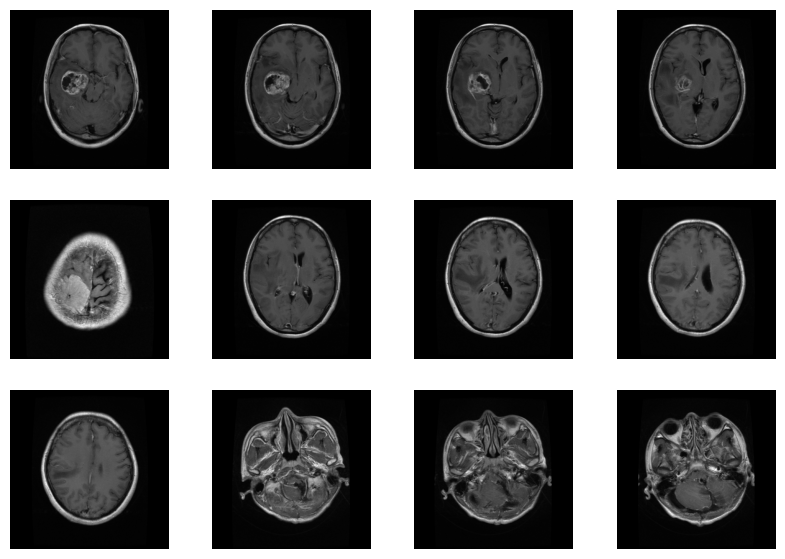

In [7]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

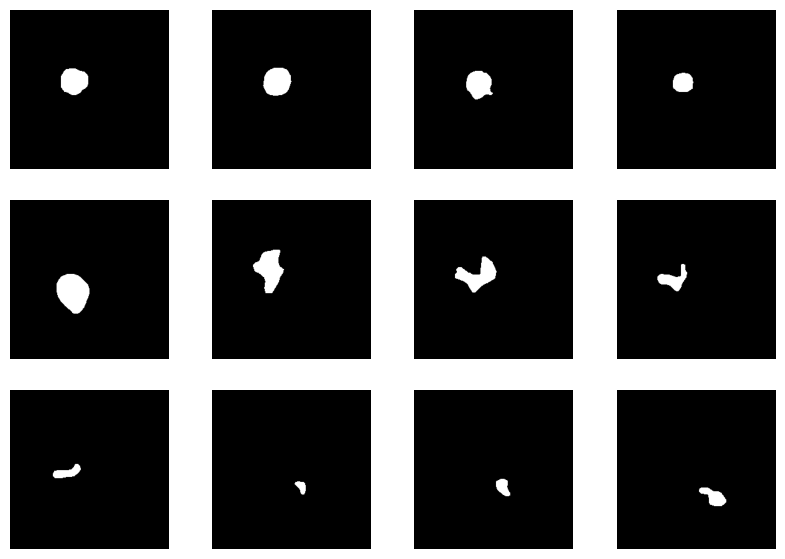

In [8]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(M[i], cmap="gray")
    plt.axis('off')
plt.show()

## Image Preprocessing

Split the data into training data, validation data, and testing data. In this case we will have a ratio of 70:15:15

In [10]:
stratify_labels = np.argmax(y, axis=1) # since the labels are already one-hot encoded
X_train, X_temp, y_train, y_temp, M_train, M_temp = train_test_split(X, y, M, test_size=0.3, random_state=42, stratify=stratify_labels)

stratify_temp = np.argmax(y_temp, axis=1)
X_val, X_test, y_val, y_test, M_val, M_test = train_test_split(X_temp, y_temp, M_temp, test_size=0.5, random_state=42, stratify=stratify_temp)

print(f'Training set: {X_train.shape}, {y_train.shape}, {M_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}, {M_val.shape}')
print(f'Testing set: {X_test.shape}, {y_test.shape}, {M_test.shape}')

Training set: (2144, 256, 256), (2144, 3), (2144, 256, 256)
Validation set: (460, 256, 256), (460, 3), (460, 256, 256)
Testing set: (460, 256, 256), (460, 3), (460, 256, 256)


# Training
## Training Preparation

## Training Process

## Saving the Model

# Training Results

# Prediction